In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
np.random.seed(42)

Dados los precios históricos de cierre ajustado de Master Card (NYSE: MA) y Pepsi (NYSE:PEP) de los últimos 3 años, imagina un portafolio a 50% y 50% de ambas acciones, con un valor inicial de 10,000 dolares.

a. Calcula los rendimientos medios diarios por acción e interprétalos 5pt.

b. Calcula la matriz de covarianza de los rendimientos e interprétala 5 pt.

c. Estima mil escenarios del valor final del portafolio 30 días después y obtén los valores del portafolio en el peor y en el mejor resultado de tu simulación. 5 pt.

d. Estima el Value at Risk (VaR) a 30 días al 1% para el portafolio especificado e interpreta el VaR resultante. 10 pt

e. Haz un histograma con los 1000 valores finales del portafolio (los 1000 valores en el día 30). 10 pts.

Carga el código utilizado con las preguntas contestadas

In [2]:
stocks = ['MA','PEP']
weights = [0.5, 0.5]
start_date = '2022-03-10'
end_date = '2025-03-10'
num_dias = 30

data = yf.download(stocks, start=start_date, end=end_date, progress=False)['Close']

YF.download() has changed argument auto_adjust default to True


## Inciso a

In [3]:
rt = data.pct_change().dropna()
rt.mean()

Ticker
MA     0.000812
PEP    0.000166
dtype: float64

En promedio MA tiene un rendimeinto diario de 0.000812, es decir, que aumenta a esa tasa todos los días.

En promedio PEP tiene un rendimeinto diario de 0.000166, es decir, que aumenta a esa tasa todos los días.

## Inciso b

In [4]:
rt.cov()

Ticker,MA,PEP
Ticker,,
MA,0.000186,0.000053
PEP,0.000053,0.000121


La covarianza lo que nos interesa es el signo, por la matriz obtenida tenemos que ambas acciones tienen una relación psoitiva (0.000053), es decir, que se mueven en la misma dirección, sin embargo nos sabemos la fuerza de esa relación, eso nos lo da la correlación.

Los valores de la diagonal principal representan la varianza diaria del activo MA: 0.000186 y PEP: 0.000121.

## Inciso c

In [5]:
def get_data(stocks, start_date, end_date):
    prices = yf.download(stocks, start_date, end_date, progress = False)["Close"]
    returns = prices.pct_change().dropna()
    mean_returns = returns.mean()
    cov_returns = returns.cov()
    return mean_returns, cov_returns, prices

def simular_precios(mean_returns, cov_returns, prices, num_dias, stocks, weights):

    N = 1000
    portfolio_return = np.dot(weights, mean_returns)

    portfolio_simulated_returns = np.zeros((num_dias, N)) # filas x columnas
    mean_returns = np.full(shape = (num_dias, len(stocks)), fill_value=portfolio_return)

    for m in range(N):
        L = np.linalg.cholesky(cov_returns)
        Z = np.random.normal(size=(num_dias, len(stocks))) # Matriz de n_dias (filas) y n_stocks (columnas)
        daily_returns = mean_returns.T + np.dot(L, Z.T)
        portfolio_simulated_returns [:, m] = np.cumprod(np.dot(weights, daily_returns) + 1)
    
    return portfolio_simulated_returns

In [6]:
mean_returns, cov_returns, prices = get_data(stocks, start_date, end_date)
portafolios_simulados = simular_precios(mean_returns, cov_returns, prices, num_dias, stocks, weights)

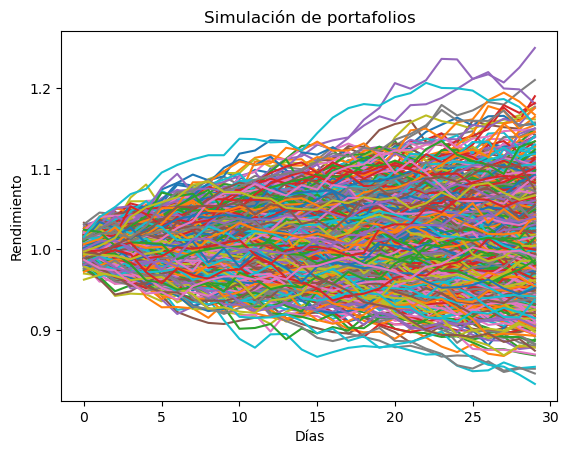

In [7]:
plt.plot(portafolios_simulados)
plt.ylabel('Rendimiento')
plt.xlabel('Días')
plt.title('Simulación de portafolios')
plt.show()

In [8]:
min_value = 10000 * portafolios_simulados[-1].min()
max_value = 10000 * portafolios_simulados[-1].max()

min_value, max_value

(8327.592902693767, 12504.373289040437)

En el peor escenario simulado el valor del portafolio a los 30 días es de 8,327.59, y en el mejor escenario simulado el valor final del portafolio a los 30 días es de 12,504.37

## Inciso d

In [9]:
pnl = portafolios_simulados[-1] - 1
var = np.percentile(pnl, 1)
var

-0.12021533631367279

El VaR nos indica que la máxima pérdida esperada del portafolio en 30 días de acuerdo a nuestras simulaciones con el 99% de confianza es de 12.02%.

## Inciso e)

In [10]:
valores = portafolios_simulados[-1] * 10000

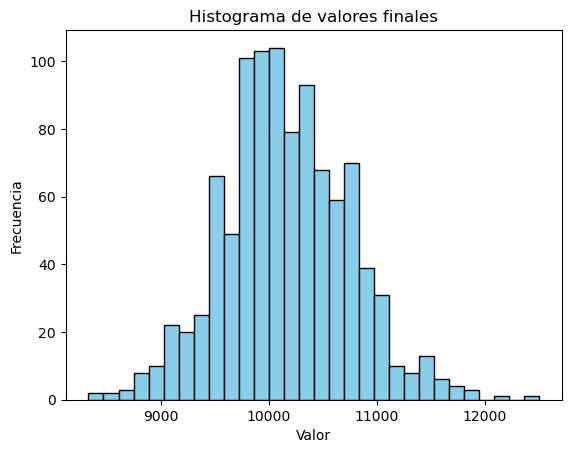

In [11]:
plt.hist(valores, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de valores finales')
plt.xlabel('Valor')
plt.ylabel('Frecuencia');